Model Setup
-----------

2D, Heat Equation with Dirichlet BC at top and bottom boundary.  No variation in the x direction.

\\[
\frac{\partial T}{\partial t} = -v \cdot \frac{\partial T}{\partial y} +k \frac{\partial^2 T}{\partial y^2}+H
\\]

\\[
\frac{\partial T}{\partial x} = 0
\\]

with $0 \leqslant x \leqslant 1 $ and $ y_{0}\leqslant y \leqslant y_{1}$

$T(y_{1}) = T_{1}$

$ -k\nabla{T}\mid_{y_{0}} = \left[\,0.0,\,f\,\right] $

------

Effectively a 1D problem in $y$-axis, described by the analytic function

$c_{0} = ( -\frac{f}{k}-\frac{h}{v} ) \cdot \frac{k}{v} \cdot \exp \left[-\frac{v}{k}y_{0} \right]$

$c_{1} = T_{1}-c_{0}\exp \left[\frac{v}{k}y_{1} \right] - \frac{h}{v}y_{1}$


$T = c_{0} \exp \left[\frac{v}{k}y\right] + \frac{h}{v}y + c_{1}$

We implement the above boundary conditions using: 
 * a `DirichletCondition` for $T(y_{1})=T_{1}$
 * a `NeumannCondition` object for $ k\nabla{T}\mid_{y_{0}} = \left[\,0.0,\,f\,\right] $

When the `NeumannCondition` object is associated with the `AdvectionDiffusion` object it defines a $T$ flux along a boundary such that:
  * $ -k\nabla T \cdot n = h $ on $ \Gamma_{h} $
  
    where:  
    * $\Gamma_{h}$ is the set of vertices along the surface of the domain,  
    * $ n $ is the unit normal facing outwards from the surface (at $n\mid_{y_{0}}=\left[0,-1\right] $)  
    * $ h $ is the scalar flow associated with the flux vector $ -k \nabla T $ along $\Gamma_{\phi}$.

An example implementation  

```
nbc = uw.conditions.NeumannCondition( fn_flux=[h], variable=tField,
                                      nodeIndexSet=mesh.specialSets["MinJ_VertexSet"] )
```

Applies a scalar flow $h$ to the `tField` over the boundary vertices in the set `nodeIndexSet`. The outward facing normal of this boundary set is used to calculate the $h$.

Here $h$ can be an `underworld.Function` or `underworld.MeshVariable` type.

In [1]:
import underworld as uw
import glucifer
import numpy as np

# for machines without matplotlib #
make_graphs = True
try:
    import matplotlib
except ImportError:
    make_graphs=False

# depth range
y0 = -0.60
y1 = 1.3

T1 = 8.0       # surface temperature
k = 6.70       # diffusivity
h = 8.0        # heat production, source term
f = 2.0        # heat flux vector
v = 2.47       # j-axis velocity component

In [2]:
# analytic solution definitions with velocity
c0 = (-f/k-h/v) * k/v * np.exp(-v/k*y0)
c1 = T1 - c0*np.exp(v/k*y1) - h/v*y1

def analyticT(y):
    return c0*np.exp(v/k*y) + h/v*y + c1

def analytic_dT_dy(y):
    return v/k*c0*np.exp(v/k*y) + h/v

In [3]:
# # without velocity
# v = 0;
# c0 = (-f+h*y0)/k
# c1 = T1 + h/(2.0*k)*y1**2 - c0*y1

# # analytic solution definitions
# def analyticT(y):
#      return -h/(2*k)*y*y + c0*y + c1

# def analytic_dT_dy(y):
#     return -h/k*y + c0

In [4]:
# build mesh and fields
mesh = uw.mesh.FeMesh_Cartesian( elementType = ("Q1"), 
                                 elementRes  = (10, 10), 
                                 minCoord    = (0., y0), 
                                 maxCoord    = (1., y1))

tField    = uw.mesh.MeshVariable(mesh=mesh, nodeDofCount=1, dataType='double')
tDotField = uw.mesh.MeshVariable(mesh=mesh, nodeDofCount=1, dataType='double')
vField    = uw.mesh.MeshVariable(mesh=mesh, nodeDofCount=2, dataType='double')

# set entire tField to T1
tField.data[:] = T1

# set constant velocity field
vField.data[:] = (0.0,v)

# define neumann condition - flux!
nbc = uw.conditions.NeumannCondition( fn_flux=-f, 
                                      variable=tField, 
                                      nodeIndexSet=(mesh.specialSets['MinJ_VertexSet']) )

# flag top boundary nodes with dirichlet conditions
bc = uw.conditions.DirichletCondition(tField, indexSetsPerDof=(mesh.specialSets['MaxJ_VertexSet']) )

# define heat eq. system
ss = uw.systems.AdvectionDiffusion( phiField       = tField,
                                    phiDotField    = tDotField,
                                    velocityField  = vField,
                                    fn_diffusivity = k,
                                    fn_sourceTerm  = h,
                                    conditions     = [bc, nbc] ) 

In [5]:
# evolve to a <1e-5 relative variation. Assume that's steady state solution.
er = 1.0
its = 0              # iteration count
tOld = tField.copy() # old temperature field

while er > 1e-5 and its < 2000:
    
    tOld.data[:] = tField.data[:] # record old values
    
    dt = ss.get_max_dt()          # get time steps
    ss.integrate(dt)              # integrate in time (solve)
    
    absErr = uw.utils._nps_2norm(tOld.data-tField.data)
    magT   = uw.utils._nps_2norm(tOld.data)
    er = absErr/magT              # calculate relative variation
    
    its += 1

print "Number of iterations",its


Number of iterations 1634


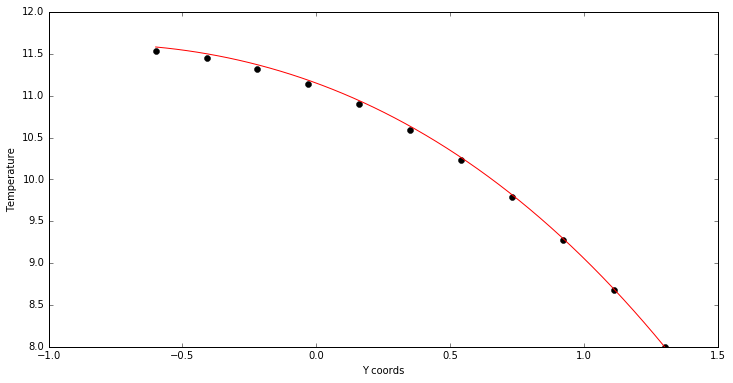

Numerical flux at y =  -0.505 is -0.42331216287
Exact flux at y= -0.505 is -0.424589706231
Abs. error  0.128516520089  magnitude (will change in parallel due to shadow space)  34.3695103704
Rel. error  0.00373925955605


In [6]:
numeric     = np.zeros(mesh.specialSets['MinI_VertexSet'].count)
ycoord      = np.zeros_like(numeric)
analytic    = np.zeros_like(numeric)

ids = mesh.specialSets['MinI_VertexSet']
numeric[:] = tField.evaluate(ids).T

ycoord = tField.mesh.data[ids.data,[1]]
analytic = analyticT(ycoord)

abserr = uw.utils._nps_2norm(analytic - numeric)
mag = uw.utils._nps_2norm(analytic)
relerr = abserr / mag

# measure border flux, analytic is easy, parallel check needed for numeric result
offset = 0.5*(mesh.maxCoord[1]-mesh.minCoord[1])/mesh.elementRes[1]
yspot = y0+offset
ana_flux = analytic_dT_dy(yspot)

tmp = tField.fn_gradient.evaluate_global([0.2,yspot])
if tmp is not None: num_flux = tmp[0][1]
else: num_flux = 0.
    
from mpi4py import MPI
comm = MPI.COMM_WORLD

# assuming order in the allgather is the same
coords = comm.allgather(ycoord)
numerical = comm.allgather(numeric)

rank = uw.rank()

if rank == 0 and make_graphs:
    # build matplot lib graph of result only on proc 0

    # 1st build exact solution hiRes
    big = np.linspace(y0,y1)
    cool = analyticT(big)

    uw.matplotlib_inline()
    import matplotlib.pyplot as pyplot
    import matplotlib.pylab as pylab
    pyplot.ion() # needed to ensure pure python jobs do now hang on show()
    pylab.rcParams[ 'figure.figsize'] = 12, 6
    pyplot.plot(coords, numerical, 'o', color = 'black', label='numerical') 
    pyplot.plot(big, cool, color = 'red', label="exact") 
    pyplot.xlabel('Y coords')
    pyplot.ylabel('Temperature')
    pyplot.show()

if rank == 0:
    threshold = 1.0e-2
    print "Numerical flux at y = " ,yspot,"is", num_flux
    print "Exact flux at y=" ,yspot,"is", ana_flux
    print "Abs. error ", abserr, " magnitude (will change in parallel due to shadow space) ", mag
    print "Rel. error ", relerr
    if relerr > threshold:
        raise RuntimeError("The numerical solution is outside the error threshold of the analytic solution." \
                           "The Relative error was ", relerr," the threshold is ", threshold)  